## Import ##

In [7]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, activations
import matplotlib.pyplot as plt
from model_profiler import model_profiler
import pathlib
from pathlib import Path
import cv2 as cv
import json
import pandas as pd
import nvidia_smi
from numba import cuda

batch_size = 5
epoch_size = 500


In [8]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


p = pathlib.Path('../../openCV_python/data/out/resized_frames/resized')
txt_files = list(p.glob('*.txt'))
img_files = [item.parent.resolve() / item.stem for item in txt_files]
txt_files[0].stem
image = txt_files[0].parent.resolve() / txt_files[0].stem

img_count = len(txt_files)
img_shape = cv.imread(str(image)).shape

txt_shape = get_txt_data(txt_files[0]).shape

input_shape = (img_count, *img_shape)
output_shape = (img_count, *txt_shape)
input_data = np.zeros(input_shape)
output_data = np.zeros(output_shape)
data = []

for i in range(len(img_files)):
    input_data[i] = cv.imread(str(img_files[i]))
    output_data[i] = get_txt_data(txt_files[i])

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    test_len = 10
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]

    return (train_images, train_labels), (test_images, test_labels)


input shape
(500, 59, 40, 3)

output shape
(500, 8)


In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()


In [10]:
input_shape = (59, 40, 3)
print(np.prod(input_shape))

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = models.Sequential()
model.add(layers.Input(input_shape))
model.add(normalization)
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2048, 'relu'))
model.add(layers.Dense(2048, 'relu'))
model.add(layers.Dense(8))

model.summary()


7080
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 59, 40, 3)        3         
 ion)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 38, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 17, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 8, 32)        0         
 2D)                                                             
                                                 

In [11]:
profile = model_profiler(model, batch_size)

print(profile)


| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0003  | BFLOPs  |
| GPU Memory Requirement           | 0.0102  | GB      |
| Model Parameters                 | 8.5596  | Million |
| Memory Required by Model Weights | 32.6521 | MB      |


In [12]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/500
90/90 [==============================] - 3s 6ms/step - loss: 6.6105 - val_loss: 3.1930
Epoch 2/500
90/90 [==============================] - 0s 3ms/step - loss: 5.0426 - val_loss: 2.6878
Epoch 3/500
90/90 [==============================] - 0s 3ms/step - loss: 3.7965 - val_loss: 2.3976
Epoch 4/500
90/90 [==============================] - 0s 3ms/step - loss: 3.8518 - val_loss: 3.0188
Epoch 5/500
90/90 [==============================] - 0s 3ms/step - loss: 3.3964 - val_loss: 2.7472
Epoch 6/500
90/90 [==============================] - 0s 3ms/step - loss: 3.0555 - val_loss: 2.2932
Epoch 7/500
90/90 [==============================] - 0s 3ms/step - loss: 2.6499 - val_loss: 1.6704
Epoch 8/500
90/90 [==============================] - 0s 3ms/step - loss: 2.4845 - val_loss: 1.5448
Epoch 9/500
90/90 [==============================] - 0s 3ms/step - loss: 2.5957 - val_loss: 1.9130
Epoch 10/500
90/90 [==============================] - 0s 3ms/step - loss: 2.5121 - val_loss: 1.7033
Epoch 11/

In [13]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [0.8696484565734863, 0.8603699803352356, 0.8580873012542725, 0.859837532043457, 0.8655369877815247, 0.9082544445991516, 0.8277361392974854, 0.865066647529602, 0.7909631729125977, 0.7609499096870422, 0.7505983710289001, 0.841223418712616, 0.8157802820205688, 0.8100767135620117, 0.8334190249443054, 0.8773545622825623, 0.7726781368255615, 0.7824695706367493, 0.8497775197029114, 0.773449718952179, 0.7822020649909973, 0.7748409509658813, 0.7135700583457947, 0.6944798231124878, 0.6843041777610779, 0.7614878416061401, 0.7481976747512817, 0.8191366195678711, 0.8947485089302063, 0.8463971614837646, 0.6439926028251648, 0.7404425144195557, 0.7264108657836914, 0.7086688280105591, 0.6926791071891785, 0.6410375833511353, 0.6943190097808838, 0.7414639592170715, 0.7012260556221008, 0.6782454252243042, 0.6540236473083496, 0.6622909307479858, 0.6768167614936829, 0.6597083806991577, 0.6566643714904785, 0.6292014718055725, 0.6881193518638611, 0.6160862445831299, 0.7130768299102783, 0.639304220676

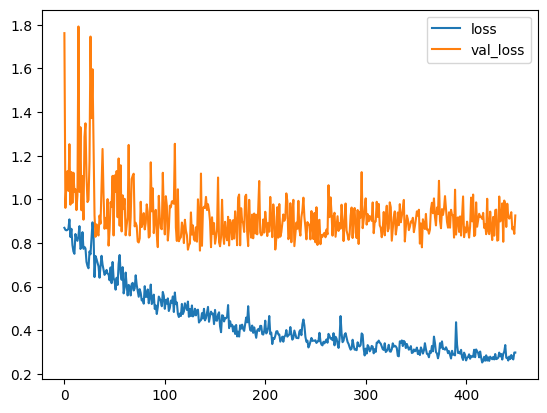

In [14]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [15]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [16]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
